#### Plot

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
def is_Exist_file(path):
    import os
    if os.path.exists(path):
        os.remove(path)


def mkdir(path):
    import os
    path = path.strip() 
    path = path.rstrip("\\") 
    isExists = os.path.exists(path) 
    if not isExists:
        os.makedirs(path) 
        print(path + ' 创建成功')
    else:
        print(path + ' 目录已存在')

In [3]:
# check otPAM of GuideSeq
def get_guideseq_otPAM(data):
    '''
    columns: otSeq
    '''
    data['length_otSeq'] = data['otSeq'].apply(lambda x: len(x))
    # print(data['length_otSeq'].value_counts())
    data = data.loc[data['length_otSeq']==23, :]
    data['otPAM'] = data['otSeq'].apply(lambda x: 'N' + x[-2:])
    pdata = pd.DataFrame(data['otPAM'].value_counts())
    pdata.rename(columns={'otPAM': 'count'}, inplace=True)
    pdata['otPAM'] = pdata.index
    sum_c = data.shape[0]
    pdata['ratio'] = pdata['count'].apply(lambda x: x*100/sum_c)
    return pdata


# add text
def add_otPAM_text(pdata, plt, xcol, ycol):
    i = 0.3
    for otPAM in pdata[xcol].unique():
        ratio = pdata.loc[otPAM, ycol]
        plt.text(i-0.4, ratio+2, round(ratio, 2), weight='bold')
        i += 1
        
        
# add text
def add_outofsearch_text(pdata, plt, xcol, ycol):
    i = 0.1
    for gRNA in pdata['sgRNA id'].unique():
        tempin = pdata.loc[(pdata['sgRNA id']==gRNA) & 
                           (pdata['Elevation-search']=='In'), :].reset_index(inplace=False)
        tempnotin = pdata.loc[(pdata['sgRNA id']==gRNA) & 
                              (pdata['Elevation-search']=='Not In'), :].reset_index(inplace=False)
        cin = tempin.loc[0, 'count']
        cnotin = tempnotin.loc[0, 'count']
        plt.text(i-0.4, cin*1.01, cin, weight='bold')
        plt.text(i, cnotin*1.01, cnotin, weight='bold')
        i += 1
        
        
def add_text2(pdata, plt, xcol, ycol):
    i = 0.3
    for x in pdata[xcol].unique():
        index = pdata.loc[pdata[xcol]==x, :].index[0]
        y = pdata.loc[index, ycol]
        plt.text(i-0.4, y+2, y, weight='bold')
        i += 1


def adjust_barwidth(ax, num_x, width=0.5):
    widthbars = [width]* num_x
    for bar,newwidth in zip(ax.patches,widthbars):
        x = bar.get_x()
        width = bar.get_width()
        centre = x+width/2.
        bar.set_x(centre-newwidth/2.)
        bar.set_width(newwidth)


# plot
def plot_barplot(pdata, xcol, ycol, xlabel, ylabel, savefig_path, 
                 figsize=(8, 4), add_text=False, hue=None, 
                 adjust_barwidth=False, order=False):
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    # 设置默认绘图风格
    plt.style.use("seaborn-white")  
    fig, ax = plt.subplots(1,1, figsize=figsize)
    if order:
        pdata_list = []
        for x in order:
            temp = pdata.loc[pdata[xcol]==x, :]
            pdata_list.append(temp)
        pdata = pd.concat(pdata_list, axis=0)
        pdata.reset_index(drop=True, inplace=True)
        ax = sns.barplot(x=xcol, y=ycol, hue=hue, data=pdata, order=order)
    else:
        ax = sns.barplot(x=xcol, y=ycol, hue=hue, data=pdata)
    ## 坐标轴不可见
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # text
    if add_text:
        add_text(pdata, plt, xcol, ycol)  
    else:
        pass
    # adjust_barwidth
    num_x = pdata.shape[0]
    if adjust_barwidth:
        adjust_barwidth(ax, num_x, width=0.5) 
    else:
        pass
    # label
    plt.xlabel(xlabel, fontsize=12, weight='bold')
    plt.ylabel(ylabel, fontsize=12, weight='bold')
    # save
    plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
    plt.show()

In [4]:
main_path = "../data"
os.chdir(main_path)

figsuplix = 'pdf'
savefig_dir = "./%s/off-target/endo-analysis"%figsuplix
mkdir(savefig_dir)

./pdf/off-target/endo-analysis 创建成功


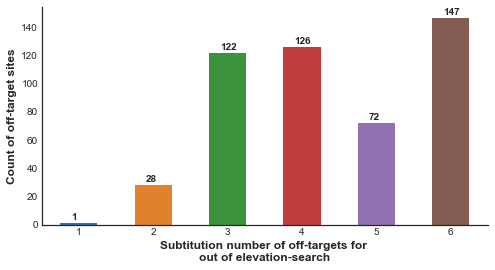

In [5]:
# check off-targets for all
pdata = pd.read_excel("./Off-Target/endo_data/self guide-seq dataset.xlsx")
pdata = pdata[['num_MM']]
pdata['count'] = 1
pdata = pdata.groupby(['num_MM']).count()
pdata.reset_index(drop=False, inplace=True)
pdata.sort_values(by='num_MM', ascending=True, inplace=True)
xcol = 'num_MM'
ycol = 'count'
xlabel = 'Subtitution number of off-targets for \nout of elevation-search'
ylabel = 'Count of off-target sites'
savefig_path = savefig_dir + '/Subtitution number of off-targets_In elevation-search.%s'%figsuplix
figsize=(8, 4)
add_text = add_text2
hue = None
adjust_barwidth = adjust_barwidth
order = pdata['num_MM'].tolist()
plot_barplot(pdata, xcol, ycol, xlabel, ylabel, savefig_path, 
                 figsize, add_text2, hue, 
                 adjust_barwidth, order)

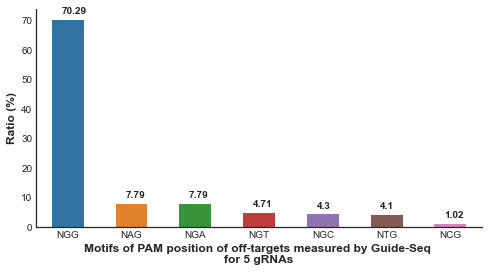

In [6]:
# check Motifs of PAM position of off-targets measured by Guide-Seq
data = pd.read_excel("./Off-Target/endo_data/self guide-seq dataset.xlsx")
gRNA_n = len(data['gRNA'].unique())
pdata = get_guideseq_otPAM(data)
xcol = "otPAM"
ycol = "ratio"
xlabel = "Motifs of PAM position of off-targets measured by Guide-Seq \nfor %s gRNAs"%(gRNA_n)
ylabel = "Ratio (%)"
savefig_path = savefig_dir + '/Motifs of PAM position of off-targets_In elevation-search.%s'%figsuplix
figsize = (8, 4)
add_text = add_otPAM_text
hue=None
adjust_barwidth = adjust_barwidth
order=False

plot_barplot(pdata, xcol, ycol, xlabel, ylabel, savefig_path, figsize, add_text, 
            hue, adjust_barwidth, order)

##### Evaluation

###### 0. 计算 ROC & PR

In [7]:
# 计算 ROC & PR
def number_MM(gRNA, otseq):
    num = 0
    for i, nucle in enumerate(gRNA[:20]):
        try:
            if nucle != otseq[i]:
                num += 1
            else:
                pass
        except IndexError as e:
            pass
    return num


## compute ROC
def compute_ROC(data, true_col, pred_col, curve='pr'):
    from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
    ytrue = data[true_col]
    ypred = data[pred_col]
    try:
        if curve == 'auc':
            score = roc_auc_score(ytrue, ypred)
        else:
            precision, recall, thresholds = precision_recall_curve(ytrue, ypred)
            x, y = precision, recall
            score = auc(recall, precision)
    except ValueError as e:
        score = 0
    return score


# evaluation data
def get_evaluation_data(data, num_MM, otPAMs=['NGG', 'NAG']):
    data['otPAM'] = data['otSeq'].apply(lambda x: 'N' + x[-2:])
    data = data.loc[data['num_MM']<=num_MM, :]
    data = data.loc[data['otPAM'].isin(otPAMs), :]
    data.reset_index(drop=True, inplace=True)
    return data


# collect 
def one_step_compute_ROC(stat_dict, data, gRNA, true_col, pred_col, num_mm, otPAMs):
    data.reset_index(drop=True, inplace=True)
    score_auc = compute_ROC(data, true_col, pred_col, 'auc')
    score_pr = compute_ROC(data, true_col, pred_col, 'pr')
    num_off_targets = data[true_col].sum()
    stat_dict['sgRNA'].append(gRNA)
    stat_dict['less than MM num'].append(num_mm)
    stat_dict['otPAMs'].append(str(otPAMs))
    stat_dict['num. of potential off-targets'].append(data.shape[0] - num_off_targets)
    stat_dict['num. of off-targets'].append(num_off_targets)
    stat_dict['model'].append(pred_col)
    stat_dict['ROC-AUC'].append(score_auc)
    stat_dict['PR-AUC'].append(score_pr)
    return stat_dict
        

def main_compute_ROC(data, num_MM_list, otPAMs_list, model_labels, true_col='ytrue'):
    stat_dict = {'sgRNA': [],
                 'less than MM num': [],
                 'otPAMs': [],
                 'num. of potential off-targets': [], 
                 'num. of off-targets': [],  
                 'model': [], 
                 'ROC-AUC': [], 
                 'PR-AUC': []
                 }
    data['num_MM'] = data.apply(lambda row: number_MM(row['wtSeq'], row['otSeq']), axis=1)
    for num_mm in num_MM_list:
        for otPAMs in otPAMs_list:
            for pred_col in model_labels:
                temp = get_evaluation_data(data, num_mm, otPAMs)
                # for all gRNAs
                gRNA = 'all'
                stat_dict = one_step_compute_ROC(stat_dict, temp, gRNA, true_col, pred_col, num_mm, otPAMs)
            # for each gRNAs
            for gRNA in temp['sgRNA id'].unique():
                one_data = temp.loc[temp['sgRNA id']==gRNA, :]
                for pred_col in model_labels:
                    stat_dict = one_step_compute_ROC(stat_dict, one_data, gRNA, true_col, pred_col, num_mm, otPAMs)
    # DataFrame
    stat_data = pd.DataFrame(stat_dict)
    return stat_data

###### 2. AUC 图

In [8]:
def get_otPAMs(otPAM_label):
    otPAMs1=['NGG', 'NAG']
    otPAMs2=['NGG', 'NAG', 'NCG', 'NTG', 
             'NGA', 'NAA', 'NCA', 'NTA', 
             'NGC', 'NAC', 'NCC', 'NTC', 
             'NGT', 'NAT', 'NCT', 'NTT'
            ]
    if otPAM_label == 'NRG':
        otPAMs = str(otPAMs1)
    elif otPAM_label == 'NNN':
        otPAMs = str(otPAMs2)
    else:
        otPAMs = ''
    return otPAMs


# evaluation data
def get_evaluation_data(data, num_MM, otPAMs=['NGG', 'NAG']):
    import copy
    pdata = copy.deepcopy(data)
    pdata['otPAM'] = pdata['otSeq'].apply(lambda x: 'N' + x[-2:])
    pdata = pdata.loc[pdata['num_MM']<=num_MM, :]
    pdata = pdata.loc[pdata['otPAM'].isin(otPAMs), :]
    pdata.reset_index(drop=True, inplace=True)
    return pdata


## plot auc
def plot_ROC(data, ytrue_col, ypred_col_dict, title, savefig_path, curve='ROC-AUC'):
    ytrue = data[ytrue_col]
    # ================================ Ploting ====================================
    colors = ['red', 'royalblue', 'darkorange', 'lightgreen', 'palevioletred', 'teal',
              'maroon', 'indigo', 'darkorchid', 'mediumorchid', 'thistle', 'pink', 'blueviolet',
              'plum', 'violet', 'purple', 'm', 'lightseagreen', 'magenta',
              'orchid', 'chartreuse', 'deeppink', 'hotpink']
    from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
    import matplotlib.pyplot as plt

    plt.figure(figsize=(6, 4))
    if len(ypred_col_dict) != 0:
        xlabel, ylabel = 'x', 'y'
        i = 0
        score_dict = {}
        for label, ypred_col in ypred_col_dict.items():
            ypred = data[ypred_col]
            if curve == 'ROC-AUC':
                score0 = roc_auc_score(ytrue, ypred)
                score = ', AUC=%s' % (round(score0, 3))
                fpr, tpr, thresholds = roc_curve(ytrue, ypred, pos_label=1)  # pos_label=1，表示值为1的实际值为正样本
                x, y = fpr, tpr
                xlabel, ylabel = 'False Postive Rate', 'True Positive Rate'
            else:
                precision, recall, thresholds = precision_recall_curve(ytrue, ypred)
                x, y = precision, recall
                score0 = auc(recall, precision)
                score = ', PR-AUC=%s' % (round(score0, 3))
                xlabel, ylabel = 'Recall', 'Precision'
                ## plot
            plt.plot(x, y, colors[i], label=label + score, linewidth=0.7)
            score_dict[ypred_col] = score0
            i += 1
        ## title
        if curve == 'ROC-AUC':
            plt.ylim(0.5, 1.025)
        plt.title(title, fontsize=12, weight='bold')
        plt.xlabel(xlabel, fontsize=12, weight='bold')
        plt.ylabel(ylabel, fontsize=12, weight='bold')
        plt.legend(prop={'weight': 'bold', 'size': 8})
        plt.savefig(savefig_path, dpi=300, bbox_inches='tight')
#         plt.close()
        plt.show()
        return score_dict